# CLPsych Classification NLP Project
Noel Ellison

## 1. Set-up Data and Packages

### 1.1 Import Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#BERT model imports
import os
import re
import numpy as np 
from sklearn.metrics import accuracy_score

import transformers
from transformers import BertTokenizer, BertModel

import torch
from torch import cuda
#from tqdm.notebook import tqdm as tqdm
from tqdm import tqdm_notebook as tqdm
device = 'cuda' if cuda.is_available() else 'cpu'
print(torch.version.cuda)

device


12.1


'cuda'

Helpful website for understanding XML data structures: https://nanonets.com/blog/parse-xml-files-using-python/#:~:text=Let's%20start%20by%20importing%20the,root%20tag%20as%20shown%20below.


Turn the XML files into a pandas DF: https://www.reddit.com/r/learnpython/comments/zh9vgw/parsing_xml_into_a_pandas_dataframe/

https://stackabuse.com/reading-and-writing-xml-files-in-python-with-pandas/

### 1.2 Read-in Source Data

#### 1.2.1 Read-in XML Files (individual posts)

In [3]:
#This code checks one XML file
from os import listdir, path
import xml.etree.ElementTree as ET
import re
import os
from lxml import etree

mypath = 'clpsych17-data/clpsych17-data/data/training/posts/post-886.xml'
#files = [path.join(mypath, f) for f in listdir(mypath) if f.endswith('.xml')]
messageIDs = []
messageBodys = []
messagePostTimes = []
authorIDs = []


tree = ET.parse(mypath)
root = tree.getroot()
for x in root[0]:
    print(x.tag, x.attrib)
    if x.tag == 'kudos':
            print(x.findall(".//count")[0].text)
    if x.tag == 'views':
            print(x.findall(".//count")[0].text)

board_id {'type': 'int'}
root {'type': 'message', 'href': '/messages/id/52'}
kudos {}
0
message_rating {'type': 'float'}
last_edit_author {'type': 'user', 'href': '/users/id/68'}
post_time {'type': 'date_time'}
last_edit_time {'type': 'date_time'}
body {'type': 'string'}
thread {'type': 'thread', 'href': '/threads/id/52'}
board {'type': 'board', 'href': '/boards/id/Games'}
parent {'type': 'message', 'href': '/messages/id/856'}
teaser {'type': 'string'}
views {}
2094
subject {'type': 'string'}
id {'type': 'int'}
read_only {'type': 'boolean'}
deleted {'type': 'boolean'}
author {'type': 'user', 'href': '/users/id/68'}


In [4]:
#Import all XML data which contains the text of the posts
from os import listdir, path
import xml.etree.ElementTree as ET
import re
import os
from lxml import etree

mypath = 'clpsych17-data/clpsych17-data/data/training/posts'
files = [path.join(mypath, f) for f in listdir(mypath) if f.endswith('.xml')]
messageIDs = []
messageBodys = []
messagePostTimes = []
authorIDs = []
kudos = []
views = []

#for file in files:
 #   print(file)
  #  tree = ET.parse(file)
   # root = tree.getroot()
    #for x in root[0]:
     #   print(x.tag, x.attrib)

for file in files:
    res = re.findall("post-(\d+).xml", file)
    if not res: continue
    messageIDs.append(res[0]) # You can append the result to a list
    tree = ET.parse(file)
    root = tree.getroot()
    for x in root[0]:
    #print(x.tag, x.attrib)
        if x.tag == 'body':
            messageBodys.append(x.text)
        if x.tag == 'post_time':
            messagePostTimes.append(x.text)
        if x.tag == 'author':
            authorIDs.append((x.attrib['href']).replace('/users/id/',''))
        if x.tag == 'kudos':
            kudos.append(x.findall(".//count")[0].text)
        if x.tag == 'views':
            views.append(x.findall(".//count")[0].text)
    if len(messageBodys) != len(messageIDs):
        messageBodys.append('')
    if len(messagePostTimes) != len(messageIDs):
        messagePostTimes.append('')
    if len(authorIDs) != len(messageIDs):
        authorIDs.append('')
    if len(kudos) != len(messageIDs):
        authorIDs.append('')
    if len(views) != len(messageIDs):
        authorIDs.append('')
    #print(res[0])


#tree.find('./message type').attrib['key']


In [5]:
print(len(messageIDs))
print(len(authorIDs))
print(len(messageBodys))
print(len(views))
print(len(kudos))
print(len(messagePostTimes))

65755
65755
65755
65755
65755
65755


In [6]:
import pandas as pd
dict = {'Message ID': messageIDs,'Author ID': authorIDs, 'Message Body': messageBodys, 'Message Views': views, 'Message Kudos': kudos, 'Message Post Time': messagePostTimes} 
    
df = pd.DataFrame(dict)

In [7]:
df.tail()

,Message ID,Author ID,Message Body,Message Views,Message Kudos,Message Post Time
65750,99987,3030,"<P>Hey <a href=""http://forums.au.reachout.com/...",451,0,2014-08-22T10:28:17+00:00
65751,99989,292,"<P><a href=""http://forums.au.reachout.com/t5/u...",745,0,2014-08-22T10:29:15+00:00
65752,99993,3030,"<P>Hey <a href=""http://forums.au.reachout.com/...",489,1,2014-08-22T10:35:29+00:00
65753,99995,292,"<P>Mwahahaha&nbsp;<img class=""emoticon emotico...",426,0,2014-08-22T10:39:06+00:00
65754,99999,5111,"I am looking forward to a new job oppurtunity,...",885,1,2014-08-22T10:44:38+00:00


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65755 entries, 0 to 65754
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Message ID         65755 non-null  object
 1   Author ID          65755 non-null  object
 2   Message Body       64371 non-null  object
 3   Message Views      65755 non-null  object
 4   Message Kudos      65755 non-null  object
 5   Message Post Time  65755 non-null  object
dtypes: object(6)
memory usage: 3.0+ MB


In [9]:
df['Message Body'][0]

'<BLOCKQUOTE><HR />FindingHope wrote:<BR />\n<P>Cassie: So my uncle was in a psych ward for about a couple of months and then when discharged, found out he was fired from his job today. It sucks that companies can have lack of compassion for people who are ill <img class="emoticon emoticon-smileysad" id="smileysad" src="http://inspire.i.lithium.com/i/smilies/16x16_smiley-sad.png" alt="Smiley Sad" title="Smiley Sad" /></P>\n<HR /></BLOCKQUOTE>\n<P>@Cassie: That seriously sucks. <img class="emoticon emoticon-smileysad" id="smileysad" src="http://inspire.i.lithium.com/i/smilies/16x16_smiley-sad.png" alt="Smiley Sad" title="Smiley Sad" /> It can be so sad when people don\'t try to take the time to understand the situation and when stigma comes into it. I hope he can find a new job without too much hassle.&nbsp;</P>'

#### 1.2.2 Read-in TSV Files (labels and author rank)

In [10]:
#Bring in classification of message
df_label = pd.read_csv('clpsych17-data/clpsych17-data/data/training/labels.tsv', sep='\t', names=['Message ID2','Label','Detail Label'])

In [11]:
df_label

,Message ID2,Label,Detail Label
0,135267,green,allClear
1,135268,green,allClear
2,135276,green,allClear
3,135277,green,allClear
4,135278,green,allClear
...,...,...,...
1183,139559,amber,followupOk
1184,139560,green,allClear
1185,139562,red,currentAcuteDistress
1186,139565,green,allClear


In [12]:
#Bring in author rankings
df_author = pd.read_csv('clpsych17-data/clpsych17-data/data/training/author_rankings.tsv', sep='\t', names=['Author ID2','Author Rank'])

In [13]:
df_author

,Author ID2,Author Rank
0,10,Community Manager
1,36,Staff
2,40,Staff
3,50,Rookie scribe
4,52,Community Manager
...,...,...
1644,6917,Visitor
1645,6930,Casual scribe
1646,6932,Rookie scribe
1647,6934,Rookie


In [14]:
df_author.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1649 entries, 0 to 1648
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Author ID2   1649 non-null   int64 
 1   Author Rank  1649 non-null   object
dtypes: int64(1), object(1)
memory usage: 25.9+ KB


In [15]:
#Convert message ID and author to integer in order to merge with tab delimited files
df['Message ID2']=df['Message ID'].astype(int)
df['Author ID2']=df['Author ID'].astype(int)

In [16]:
#Merge message text with classification
df_new1=df.merge(df_label, how='inner', on='Message ID2')

In [17]:
#Merge message data (with label) with author ID
df_new=df_new1.merge(df_author, how='left', on='Author ID2')
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188 entries, 0 to 1187
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Message ID         1188 non-null   object
 1   Author ID          1188 non-null   object
 2   Message Body       1188 non-null   object
 3   Message Views      1188 non-null   object
 4   Message Kudos      1188 non-null   object
 5   Message Post Time  1188 non-null   object
 6   Message ID2        1188 non-null   int32 
 7   Author ID2         1188 non-null   int32 
 8   Label              1188 non-null   object
 9   Detail Label       1188 non-null   object
 10  Author Rank        1188 non-null   object
dtypes: int32(2), object(9)
memory usage: 92.9+ KB


In [18]:
#Check one record on the merge
df_new[df_new['Message ID2']==135284]

,Message ID,Author ID,Message Body,Message Views,Message Kudos,Message Post Time,Message ID2,Author ID2,Label,Detail Label,Author Rank
7,135284,5155,Redhead: aaaaarrrrgggg getting really sick of ...,201,0,2015-04-24T06:23:04+00:00,135284,5155,crisis,crisis,Uber contributor


## 2. Data Pre-processing
In this section I pre-process the data.

### 2.1 Posts for ReachOut.com Staff
In this section, I look into the annotated posts for ReacOut.com Staff to see if they should be included in the dataset. I conclude that they should be included since there were 2 moderators with "Amber" posts and since moderators can be trained volunteers, it could be that the moderators themselves need help. The content of these 2 posts was indeed concerning, so I think we should categorize all posts including the staff.

There were 97 posts from staff members that were annotated and only 2 were classified as "Amber." I think that the addition 95 "Green" posts will provide good positive examples of "Green" posts, so it is also good to leave these in the dataset.

In [19]:
#Look at distribution of author rankings, see if annotations were done for staff
df_new['Author Rank'].value_counts()

Author Rank
Uber contributor             680
Star contributor             234
Casual scribe                 74
Mod                           49
Mod Squad                     43
Rookie scribe                 35
Super frequent scribe         27
Frequent scribe               22
Visitor                        7
Rookie                         7
Special Guest Contributor      5
Post Mod                       2
Youth Ambassador               2
Frequent Visitor               1
Name: count, dtype: int64

<Axes: xlabel='Author Rank'>

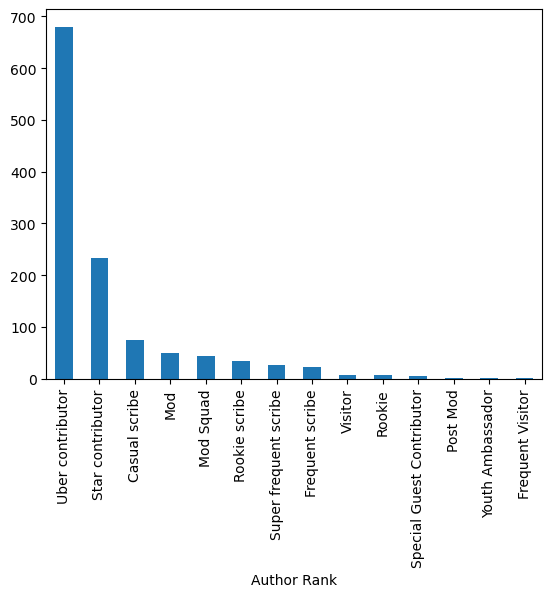

In [20]:
#Look at break-down of categories
df_new['Author Rank'].value_counts().plot(kind='bar')

In [21]:
#Look at records for those who work at ReachOut (Community Manager, Mod, Mod in Training, Mod Squad, Reachout.com Crew, Special Guest Contributor, Staff)
reachout_staff = ['Community Manager', 'Mod', 'Mod in Training', 'Mod Squad', 'Reachout.com Crew', 'Special Guest Contributor', 'Staff']
df_staff=df_new[df_new['Author Rank'].isin(reachout_staff)]
df_staff['Label'].value_counts()

Label
green    95
amber     2
Name: count, dtype: int64

In [22]:
pd.set_option('display.max_colwidth', None)
df_staff[df_staff['Label']=='amber']['Message Body']

601     Hey guys,<BR /><BR />Long time no see. <img class="emoticon emoticon-smileytongue" id="smileytongue" src="http://inspire.i.lithium.com/i/smilies/16x16_smiley-tongue.png" alt="Smiley Tongue" title="Smiley Tongue" /> Been busy with Assignments and have been binging on Netflix and thinking a lot about what both my psychologist and Dr said.<BR /><BR />They pretty much hate all these new fandangle terms for sexuality and pretty much don't believe in the term demi. They think I am romantically and sexually repressed. But I've had relationships and crushes since the incident they are referring to. So confused. Especially when it came from someone I trust. Not at all what I was expecting.<BR /><BR />Just got to remember that only I can define my sexuality.
1025                                                                                                                                                                                                                                     

In [23]:
df_staff[df_staff['Label']=='amber']['Author Rank']

601     Mod
1025    Mod
Name: Author Rank, dtype: object

In [24]:
#Use this code if we want to remove ReachOut.com staff
#test_df = df_new[~df_new['Author Rank'].isin(reachout_staff)]
#test_df['Author Rank'].value_counts()

### 2.2 Isolate Emojis
In this section, I pull out the emoji information from the message body so it can be included as a feature. I intend to remove the HTML tags from the message body, but this also removes the emoji information. I wanted to keep that information because I think it could speak to emotional distress or stability. I didn't just keep the description of the emoji but also the prefix text **"emoticon-"** so that the model would treat this as emoji information.

In [25]:
#Isolate emoji text
#Find the position of <img
df_new['pos_emoji'] = df_new['Message Body'].str.find('<img')

#Use position to slice using a lambda function, this is the portion of the emoji line I am interested in
#Originally had x['pos_emoji'] thru the end of the line to confirm that there was no additiona information needed
df_new['emoji_text_full'] = df_new.apply(lambda x: x['Message Body'][x['pos_emoji']+20:x['pos_emoji']+50], axis=1)

#Find the end of the emoji string
df_new['end_pos_emoji'] =  df_new['emoji_text_full'].str.find('"')

#Slice and cut-off remaining emoji text
df_new['emoji_text'] = df_new.apply(lambda x: x['emoji_text_full'][0:x['end_pos_emoji']], axis=1)

#Look at the distribution of emojis in training data
emoji_data=df_new[df_new['pos_emoji']>0]

In [26]:
#Remove emoji text if no emojis were used in the message
df_new['Emoji Text'] = df_new.apply(lambda x: x['emoji_text'] if x['pos_emoji']>=0 else '', axis=1)

In [27]:
df_new['Emoji Text'].value_counts()

Emoji Text
                               915
 emoticon-smileyhappy          138
 emoticon-smileysad             41
 emoticon-smileyvery-happy      34
 emoticon-smileytongue          31
 emoticon-smileywink             6
 emoticon-heart                  5
 emoticon-smileysurprised        4
 emoticon-cathappy               2
 emoticon-smileyfrustrated       2
 emoticon-smileyindifferent      2
 emoticon-manmad                 1
 emoticon-manfrustrated          1
 emoticon-manvery-happy          1
 emoticon-womanlol               1
 emoticon-smileymad              1
 emoticon-cattongue              1
 emoticon-catsad                 1
 emoticon-catvery-happy          1
Name: count, dtype: int64

<Axes: xlabel='Emoji Text'>

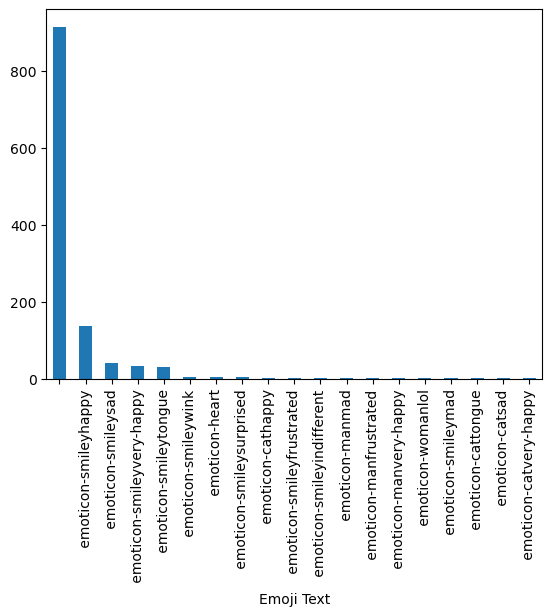

In [28]:
df_new['Emoji Text'].value_counts().plot(kind='bar')

### 2.3 Add Date and Time Features
In this section, I use the date/time that the post was made to derive features that I think may be important:

- **Hour**: The hour that the post was made. Studies show that suicides are more prevelant between midnight and 6 am.
- **Day of Week**: The day of the week that the post was made. Studies show that suicides are more likely to occurr on Sundays and Mondays.
- **Month**: The month that the post was made. I have not researched this, but imagine that suicides may be higher around the holidays

In [29]:
#Create date and time variables to be added as features
import datetime
import calendar

# datetime in string format for may 25 1999
input = '2021/05/25'
format = '%Y/%m/%d'
 
#Get message date and time as separate variables
df_new['pos_time'] = df_new['Message Post Time'].str.find('T')
df_new['pos_plus'] = df_new['Message Post Time'].str.find('+')

#Use position to slice and get date only
df_new['Date'] = df_new.apply(lambda x: x['Message Post Time'][0:x['pos_time']], axis=1)

df_new['Time'] = df_new.apply(lambda x: x['Message Post Time'][x['pos_time']+1:x['pos_plus']], axis=1)
df_new['Hour'] = df_new.apply(lambda x: x['Time'][0:2], axis=1)

# convert from string format to datetime format
df_new['Datetime'] = pd.to_datetime(df_new['Date'], format='%Y-%m-%d')
df_new['Month'] = df_new.apply(lambda x: x['Datetime'].strftime("%B"), axis=1)

#Monday=0, Sunday=6
df_new['Day of Week'] = df_new['Datetime'].dt.dayofweek

#Replace the numeric day of the week with the name of the day
daynames = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
df_new['Day of Week'].replace(daynames, inplace=True)

#Look at results to confirm accuracy
print(df_new[['Message Post Time', 'Datetime', 'Date', 'Time','Hour','Day of Week','Month']].head(3))

#Look at times
#df_new['what_time'] = df_new['Message Post Time'].str.find('T2')
#df_new[df_new['what_time']>0]

           Message Post Time   Datetime        Date      Time Hour  \
0  2015-04-24T03:49:50+00:00 2015-04-24  2015-04-24  03:49:50   03   
1  2015-04-24T04:01:22+00:00 2015-04-24  2015-04-24  04:01:22   04   
2  2015-04-24T04:43:34+00:00 2015-04-24  2015-04-24  04:43:34   04   

  Day of Week  Month  
0      Friday  April  
1      Friday  April  
2      Friday  April  


### 2.4 Remove HTML Tags from Text
In this section, I remove HTML tags from the text to make it more readable. I have also retained the raw text as I intend to compare the performance of my LLMs on text with and without HTML tags.

In [30]:
#Drop variables used for derivations and only keep variables of interest
df_red=df_new[['Message ID2', 'Author ID2', 'Label', 'Author Rank', 'Message Body', 'Emoji Text', 'Day of Week', 'Hour', 'Date', 'Datetime', 'Month', 'Time', 'Message Views', 'Message Kudos']]
df_red.tail((2))

,Message ID2,Author ID2,Label,Author Rank,Message Body,Emoji Text,Day of Week,Hour,Date,Datetime,Month,Time,Message Views,Message Kudos
1186,139565,5155,green,Uber contributor,"Looking forward to seeing my aunt tomorrow who I haven't seen in years, she is coming to Tassie for work and taking me out for dinner. Should be great.",,Sunday,12,2015-06-07,2015-06-07,June,12:16:09,214,2
1187,139568,5111,green,Uber contributor,Just keeping going minute by minute j,,Sunday,12,2015-06-07,2015-06-07,June,12:46:45,144,0


In [31]:
#Add variable for text without HTML tags
#df_new2=df_new.replace(to_replace="<[^>]*>|\n|&nbsp;", value="", regex=True)
df_red['Message Body no HTML']=df_red['Message Body'].replace(to_replace="<[^>]*>|\n|&nbsp;", value="", regex=True)
df_red.head((2))

,Message ID2,Author ID2,Label,Author Rank,Message Body,Emoji Text,Day of Week,Hour,Date,Datetime,Month,Time,Message Views,Message Kudos,Message Body no HTML
0,135267,5111,green,Uber contributor,<P>JAN<BR /> <BR />FEB<BR /> <BR />MAR<BR /> <BR />APR</P>\n<P>17th: - J95!&nbsp;<BR /> <BR />MAY<BR /> <BR />JUN<BR /> <BR />JUL<BR />19th: Sophie!!<BR /> <BR />AUG<BR /> <BR />SEP<BR /> <BR />OCT<BR /> <BR />NOV <BR /> <BR />DEC</P>,,Friday,03,2015-04-24,2015-04-24,April,03:49:50,519,0,JAN FEB MAR APR17th: - J95! MAY JUN JUL19th: Sophie!! AUG SEP OCT NOV DEC
1,135268,5111,green,Uber contributor,"<P><div class=""video-embed-center video-embed-youtube""><iframe src=""http://www.youtube.com/embed/K_EjSuYWzxA"" width=""320"" height=""265"" frameborder=""0"" allowfullscreen=""true""></iframe></div></P>\n<P>&nbsp;</P>\n<P>Big Scary - Luck Now.&nbsp;</P>",,Friday,04,2015-04-24,2015-04-24,April,04:01:22,207,0,Big Scary - Luck Now.


In [32]:
#Look at two observations to compare how the text with and without HTML tags looks
pd.set_option('display.max_colwidth', None)
df_red[df_red['Message ID2']==135284]['Message Body']

7    Redhead: aaaaarrrrgggg getting really sick of this hypomania. When will this end. getting so agitated, bored. And its raining so I can't even get out for a walk to calm down. what to do. Its starting to make me feel unsafe...<img class="emoticon emoticon-smileysad" id="smileysad" src="http://inspire.i.lithium.com/i/smilies/16x16_smiley-sad.png" alt="Smiley Sad" title="Smiley Sad" /> sorry for being so negative again
Name: Message Body, dtype: object

In [33]:
df_red[df_red['Message ID2']==135284]['Message Body no HTML']

7    Redhead: aaaaarrrrgggg getting really sick of this hypomania. When will this end. getting so agitated, bored. And its raining so I can't even get out for a walk to calm down. what to do. Its starting to make me feel unsafe... sorry for being so negative again
Name: Message Body no HTML, dtype: object

In [34]:
df_red[df_red['Message ID2']==135284]['Emoji Text']

7     emoticon-smileysad
Name: Emoji Text, dtype: object

### 2.5 Map Labels to Numeric Values
Some of the LLMs I intend to use need categories in numbers instead of text, so I create a new variable (Label Num) to contain this information.

In [35]:
#Map the label to a numerical value because this is needed for BERT instead of the text
#to_rep = {'green': 0, 'amber': 1, 'red': 2, 'crisis': 3}
to_num = {'green': 0, 'amber': 1, 'red': 2, 'crisis': 3}
df_red['Label Num']=df_red['Label']
df_red.replace({'Label Num': to_num}, inplace=True)

### 2.6 Create Text + Features Variable
The research I did indicated that prepending the additional features as text to the message body could improve the accuracy of my LLM. I added the following information to the beginning of the message text:

- **Author Rank**: "My author rank is XXXXX."
- **Day**: "It is XXXXX."
- **Month**: "The month is XXXXX."
- **Emoji Text**: "emoticon-XXXXXXXX."
- **Views**: "This post has XXXX views."
- **Kudos**: "This post has XXXX kudos."

In [36]:
#Combine text and features
df_red['Text and Features'] = "My author rank is " + df_red['Author Rank'] + "." \
                            + " I posted this on " + df_red['Day of Week'] +"." \
                            + " The time is " + df_red['Hour'] + " oclock." \
                            + " The month is " + df_red['Month'] + ". " \
                            + df_red['Emoji Text'] \
                            + " This post has " + df_red['Message Views'] + " views." \
                            + " This post has " + df_red['Message Kudos'] + " kudos." \
                            + df_red['Message Body no HTML']
print(df_red[['Author Rank', 'Day of Week', 'Hour', 'Month','Message Views','Message Kudos','Message Body no HTML', 'Text and Features']].head(1))

        Author Rank Day of Week Hour  Month Message Views Message Kudos  \
0  Uber contributor      Friday   03  April           519             0   

                                                         Message Body no HTML  \
0  JAN FEB MAR APR17th: - J95! MAY JUN JUL19th: Sophie!! AUG SEP OCT NOV  DEC   

                                                                                                                                                                                                                    Text and Features  
0  My author rank is Uber contributor. I posted this on Friday. The time is 03 oclock. The month is April.  This post has 519 views. This post has 0 kudos.JAN FEB MAR APR17th: - J95! MAY JUN JUL19th: Sophie!! AUG SEP OCT NOV  DEC  


### 2.7 Split into Train and Validation
I used a 90-10 split for training and validation data. For the CLPsych project, they provided a separate testing dataset. I intend to use their "Training" data as training and validation and then apply my final model to their "Testing" data. However, the code does refer to the validaiton dataset as "test" since I used code from previous homeworks and this is what I had called the validation dataset.

After all my model tweaking and testing, I will apply the best LLM to the true testing dataset and check its accuracy.

In [37]:
#Create variable in dataset for groupped labels
#Crisis vs. Other
to_num_crisis = {'green': 0, 'amber': 0, 'red': 0, 'crisis': 1}
df_red['Label Num Crisis']=df_red['Label']
df_red.replace({'Label Num Crisis': to_num_crisis}, inplace=True)

#Red vs. Other
to_num_red = {'green': 0, 'amber': 0, 'red': 1, 'crisis': 0}
df_red['Label Num Red']=df_red['Label']
df_red.replace({'Label Num Red': to_num_red}, inplace=True)

#Amber vs. Other
to_num_amber = {'green': 0, 'amber': 1, 'red': 0, 'crisis': 0}
df_red['Label Num Amber']=df_red['Label']
df_red.replace({'Label Num Amber': to_num_amber}, inplace=True)

#Green vs. Other
to_num_green = {'green': 1, 'amber': 0, 'red': 0, 'crisis': 0}
df_red['Label Num Green']=df_red['Label']
df_red.replace({'Label Num Green': to_num_green}, inplace=True)

In [41]:
import os
import re
import numpy as np 
from sklearn.metrics import accuracy_score

import transformers
from transformers import BertTokenizer, BertModel

import torch
from torch import cuda
#from tqdm.notebook import tqdm as tqdm
from tqdm import tqdm_notebook as tqdm
device = 'cuda' if cuda.is_available() else 'cpu'
print(torch.version.cuda)

device

12.1


'cuda'

### 3. RoBERTa Message Body with HTML Text Removed

In [39]:
#Separate data into test/train
np.random.seed(42)
test = df_red.sample(frac=0.1)
train = df_red[~df_red.index.isin(test.index)]

In [40]:
from sklearn.metrics import f1_score

In [41]:
#Split test and training data into X and Y
train_X = train['Message Body no HTML'].to_list()
test_X = test['Message Body no HTML'].to_list()

In [42]:
train_y = train['Label Num'].to_list()
test_y = test['Label Num'].to_list()

len(train_X), len(train_y)

(1069, 1069)

In [43]:
class MultiLabelDataset(torch.utils.data.Dataset):

    #Initializer function
    #Self references what it is within this class
    def __init__(self, text, labels, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = text
        self.targets = labels
        self.max_len = max_len

    #Return lenght of text
    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,                                  
            truncation=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }

In [44]:
from transformers import RobertaConfig, RobertaModel

# Initializing a RoBERTa configuration
configuration = RobertaConfig()

# Initializing a model (with random weights) from the configuration
#model = RobertaModel(configuration)

# Accessing the model configuration
#configuration = model.config

In [45]:
class BERTClass(torch.nn.Module):
    def __init__(self, NUM_OUT):
        super(BERTClass, self).__init__()
                   
        self.l1 = RobertaModel(configuration)
#         self.pre_classifier = torch.nn.Linear(768, 256)
        self.classifier = torch.nn.Linear(768, NUM_OUT)
#         self.dropout = torch.nn.Dropout(0.5)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
#         pooler = self.pre_classifier(pooler)
#         pooler = torch.nn.Tanh()(pooler)
#         pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        output = self.softmax(output)
        return output

In [46]:
def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss()(outputs, targets)

def train(model, training_loader, optimizer):
    model.train()
    for data in tqdm(training_loader):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss
    
def validation(model, testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for data in tqdm(testing_loader):
            targets = data['targets']
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            outputs = torch.sigmoid(outputs).cpu().detach()
            fin_outputs.extend(outputs)
            fin_targets.extend(targets)
    return torch.stack(fin_outputs), torch.stack(fin_targets)

In [47]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained("FacebookAI/roberta-base")

# what does the tokenizer do?
print(train_X[5])

tokenizer.encode_plus(
            train_X[5],
            None,
            add_special_tokens=True,
            max_length=350,
            pad_to_max_length=True,
            truncation=True,
            return_token_type_ids=True
        )

@Sophie-RO I need to say something but I dont know how


{'input_ids': [0, 1039, 104, 6673, 324, 12, 8727, 38, 240, 7, 224, 402, 53, 38, 33976, 216, 141, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [48]:
MAX_LEN = 350
BATCH_SIZE = 64
EPOCHS = 3
NUM_OUT = 4 # 7 classifications
LEARNING_RATE = 2e-05

train_y2 = torch.tensor(train_y, dtype=torch.long, device=device)
test_y2 = torch.tensor(test_y, dtype=torch.long, device=device)

training_data = MultiLabelDataset(train_X, train_y2, tokenizer, MAX_LEN)
test_data = MultiLabelDataset(test_X, test_y2, tokenizer, MAX_LEN)

train_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }    

training_loader = torch.utils.data.DataLoader(training_data, **train_params)
testing_loader = torch.utils.data.DataLoader(test_data, **test_params)

In [49]:
#Run on Body with HTML codes
model = BERTClass(NUM_OUT)
model.to(device)   

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    loss = train(model, training_loader, optimizer)
    print(f'Epoch: {epoch}, Loss:  {loss.item()}')  
    guess, targs = validation(model, testing_loader)
 
    guesses = torch.max(guess, dim=1)    
    
    print('Acurracy on test set {}'.format(accuracy_score(guesses.indices.cpu().numpy(), targs.cpu().numpy())))
    print('F1 on test set {}'.format(f1_score(guesses.indices.cpu().numpy(), targs.cpu().numpy(), average='weighted')))


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 0, Loss:  1.0992295742034912


  0%|          | 0/2 [00:00<?, ?it/s]

Acurracy on test set 0.6554621848739496
F1 on test set 0.7918781725888325


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 1, Loss:  1.321437954902649


  0%|          | 0/2 [00:00<?, ?it/s]

Acurracy on test set 0.6554621848739496
F1 on test set 0.7918781725888325


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 2, Loss:  1.1214498281478882


  0%|          | 0/2 [00:00<?, ?it/s]

Acurracy on test set 0.6554621848739496
F1 on test set 0.7918781725888325


In [51]:
test_result = pd.DataFrame({'Predicted': guesses.indices.cpu().numpy(), 'Actual': targs.cpu().numpy()}, columns=['Predicted', 'Actual'])

In [52]:
predicted= guesses.indices.cpu().numpy()

In [53]:
actual=targs.cpu().numpy()

In [54]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Green', 'Amber', 'Red', 'Crisis'])

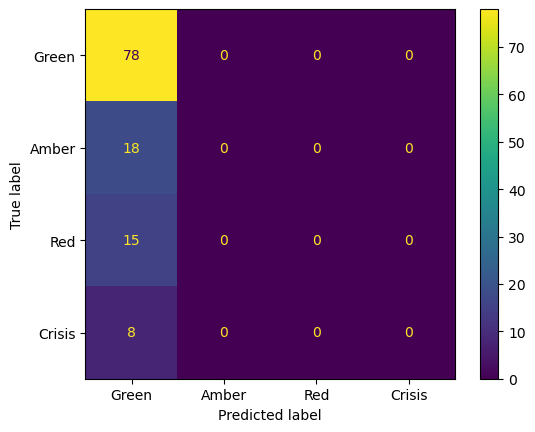

In [55]:
cm_display.plot()

In [57]:
plist=predicted.tolist()

In [59]:
predicted

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

### 4. Run Separate Models for Each Classification

In [208]:
#Create variable in dataset for groupped labels
#Crisis vs. Other
to_num_crisis = {'green': 0, 'amber': 0, 'red': 0, 'crisis': 1}
df_red['Label Num Crisis']=df_red['Label']
df_red.replace({'Label Num Crisis': to_num_crisis}, inplace=True)

#Red vs. Other
to_num_red = {'green': 0, 'amber': 0, 'red': 1, 'crisis': 0}
df_red['Label Num Red']=df_red['Label']
df_red.replace({'Label Num Red': to_num_red}, inplace=True)

#Amber vs. Other
to_num_amber = {'green': 0, 'amber': 1, 'red': 0, 'crisis': 0}
df_red['Label Num Amber']=df_red['Label']
df_red.replace({'Label Num Amber': to_num_amber}, inplace=True)

#Green vs. Other
to_num_green = {'green': 1, 'amber': 0, 'red': 0, 'crisis': 0}
df_red['Label Num Green']=df_red['Label']
df_red.replace({'Label Num Green': to_num_green}, inplace=True)

In [209]:
df_red['Label Num Green'].value_counts()

Label Num Green
1    715
0    473
Name: count, dtype: int64

In [210]:
df_red['Label'].value_counts()

Label
green     715
amber     296
red       137
crisis     40
Name: count, dtype: int64

In [211]:
from sklearn.metrics import f1_score

In [212]:
np.random.seed(42)
test = df_red.sample(frac=0.1)
train = df_red[~df_red.index.isin(test.index)]

In [213]:
#Split test and training data into X and Y
train_X = train['Message Body no HTML'].to_list()
test_X = test['Message Body no HTML'].to_list()

train_yc = train['Label Num Crisis'].to_list()
test_yc = test['Label Num Crisis'].to_list()

train_yr = train['Label Num Red'].to_list()
test_yr = test['Label Num Red'].to_list()

train_ya = train['Label Num Amber'].to_list()
test_ya = test['Label Num Amber'].to_list()

train_yg = train['Label Num Green'].to_list()
test_yg = test['Label Num Green'].to_list()

train_messageid = train['Message ID2'].to_list()
test_messageid = test['Message ID2'].to_list()

In [214]:
#Initializer function
class MultiLabelDataset(torch.utils.data.Dataset):

    #Initializer function
    #Self references what it is within this class
    def __init__(self, text, labels, tokenizer, max_len, message_id):
        self.tokenizer = tokenizer
        self.text = text
        self.targets = labels
        self.max_len = max_len
        self.message_id = message_id

    #Return lenght of text
    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,                                  
            truncation=True,
            return_token_type_ids=True
        )        
        messageid = self.message_id[index]
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'messageid': torch.tensor(messageid, dtype=torch.long),
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }

class BERTClass(torch.nn.Module):
    def __init__(self, NUM_OUT):
        super(BERTClass, self).__init__()
                   
        self.l1 = BertModel.from_pretrained("bert-base-uncased")
#         self.pre_classifier = torch.nn.Linear(768, 256)
        self.classifier = torch.nn.Linear(768, NUM_OUT)
#         self.dropout = torch.nn.Dropout(0.5)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
#         pooler = self.pre_classifier(pooler)
#         pooler = torch.nn.Tanh()(pooler)
#         pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        output = self.softmax(output)
        return output

def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss()(outputs, targets)

def train(model, training_loader, optimizer):
    model.train()
    for data in tqdm(training_loader):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss
    
def validation(model, testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    id_outputs=[]
    with torch.no_grad():
        for data in tqdm(testing_loader):
            targets = data['targets']
            messageids = data['messageid']            
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            outputs = torch.sigmoid(outputs).cpu().detach()
            fin_outputs.extend(outputs)
            fin_targets.extend(targets)
            id_outputs.extend(messageids)
    return torch.stack(fin_outputs), torch.stack(fin_targets), torch.stack(id_outputs) 

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# what does the tokenizer do?
print(train_X[5])

tokenizer.encode_plus(
            train_X[5],
            None,
            add_special_tokens=True,
            max_length=30,
            pad_to_max_length=True,
            truncation=True,
            return_token_type_ids=True
        )

@Sophie-RO I need to say something but I dont know how


{'input_ids': [101, 1030, 8234, 1011, 20996, 1045, 2342, 2000, 2360, 2242, 2021, 1045, 2123, 2102, 2113, 2129, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [215]:
MAX_LEN = 350
BATCH_SIZE = 64
EPOCHS = 3
NUM_OUT = 2
LEARNING_RATE = 2e-05
   
train_yc2 = torch.tensor(train_yc, dtype=torch.long, device=device)
test_yc2 = torch.tensor(test_yc, dtype=torch.long, device=device)
train_yr2 = torch.tensor(train_yr, dtype=torch.long, device=device)
test_yr2 = torch.tensor(test_yr, dtype=torch.long, device=device)
train_ya2 = torch.tensor(train_ya, dtype=torch.long, device=device)
test_ya2 = torch.tensor(test_ya, dtype=torch.long, device=device)
train_yg2 = torch.tensor(train_yg, dtype=torch.long, device=device)
test_yg2 = torch.tensor(test_yg, dtype=torch.long, device=device)

training_datac = MultiLabelDataset(train_X, train_yc2, tokenizer, MAX_LEN, train_messageid)
test_datac = MultiLabelDataset(test_X, test_yc2, tokenizer, MAX_LEN, test_messageid)
training_datar = MultiLabelDataset(train_X, train_yr2, tokenizer, MAX_LEN, train_messageid)
test_datar = MultiLabelDataset(test_X, test_yr2, tokenizer, MAX_LEN, test_messageid)
training_dataa = MultiLabelDataset(train_X, train_ya2, tokenizer, MAX_LEN, train_messageid)
test_dataa = MultiLabelDataset(test_X, test_ya2, tokenizer, MAX_LEN, test_messageid)
training_datag = MultiLabelDataset(train_X, train_yg2, tokenizer, MAX_LEN, train_messageid)
test_datag = MultiLabelDataset(test_X, test_yg2, tokenizer, MAX_LEN, test_messageid)

train_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }    

training_loaderc = torch.utils.data.DataLoader(training_datac, **train_params)
testing_loaderc = torch.utils.data.DataLoader(test_datac, **test_params)
training_loaderr = torch.utils.data.DataLoader(training_datar, **train_params)
testing_loaderr = torch.utils.data.DataLoader(test_datar, **test_params)
training_loadera = torch.utils.data.DataLoader(training_dataa, **train_params)
testing_loadera = torch.utils.data.DataLoader(test_dataa, **test_params)
training_loaderg = torch.utils.data.DataLoader(training_datag, **train_params)
testing_loaderg = torch.utils.data.DataLoader(test_datag, **test_params)

In [216]:
#Run on Body with HTML codes
modelc = BERTClass(NUM_OUT)
modelc.to(device)   
modelr = BERTClass(NUM_OUT)
modelr.to(device)   
modela = BERTClass(NUM_OUT)
modela.to(device)   
modelg = BERTClass(NUM_OUT)
modelg.to(device)   

optimizerc = torch.optim.Adam(params =  modelc.parameters(), lr=LEARNING_RATE)
optimizerr = torch.optim.Adam(params =  modelr.parameters(), lr=LEARNING_RATE)
optimizera = torch.optim.Adam(params =  modela.parameters(), lr=LEARNING_RATE)
optimizerg = torch.optim.Adam(params =  modelg.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):

    print('Crisis Model')
    lossc = train(modelc, training_loaderc, optimizerc)
    print(f'Epoch: {epoch}, Loss:  {lossc.item()}')  
    guessc, targsc, ids_c = validation(modelc, testing_loaderc)
    guessesc = torch.max(guessc, dim=1) 
    
    print('Acurracy of Crisis Model on test set {}'.format(accuracy_score(guessesc.indices.cpu().numpy(), targsc.cpu().numpy())))
    print('F1 of Crisis Model on test set {}'.format(f1_score(guessesc.indices.cpu().numpy(), targsc.cpu().numpy(), average='weighted')))
    
    print('Red Model')
    lossr = train(modelr, training_loaderr, optimizerr)
    print(f'Epoch: {epoch}, Loss:  {lossr.item()}')  
    guessr, targsr, ids_r = validation(modelr, testing_loaderr)
    guessesr = torch.max(guessr, dim=1) 
    
    print('Acurracy of Red Model on test set {}'.format(accuracy_score(guessesr.indices.cpu().numpy(), targsr.cpu().numpy())))
    print('F1 of Red Model on test set {}'.format(f1_score(guessesr.indices.cpu().numpy(), targsr.cpu().numpy(), average='weighted')))   

    print('Amber Model')
    lossa = train(modela, training_loadera, optimizera)
    print(f'Epoch: {epoch}, Loss:  {lossa.item()}')  
    guessa, targsa, ids_a = validation(modela, testing_loadera)
    guessesa = torch.max(guessa, dim=1) 
    
    print('Acurracy of Amber Model on test set {}'.format(accuracy_score(guessesa.indices.cpu().numpy(), targsa.cpu().numpy())))
    print('F1 of Amber Model on test set {}'.format(f1_score(guessesa.indices.cpu().numpy(), targsa.cpu().numpy(), average='weighted')))

    print('Green Model')
    lossg = train(modelg, training_loaderg, optimizerg)
    print(f'Epoch: {epoch}, Loss:  {lossg.item()}')  
    guessg, targsg, ids_g = validation(modelg, testing_loaderg)
    guessesg = torch.max(guessg, dim=1) 
    
    print('Acurracy of Green Model on test set {}'.format(accuracy_score(guessesg.indices.cpu().numpy(), targsg.cpu().numpy())))
    print('F1 of Green Model on test set {}'.format(f1_score(guessesg.indices.cpu().numpy(), targsg.cpu().numpy(), average='weighted')))

Crisis Model


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 0, Loss:  0.3591245114803314


  0%|          | 0/2 [00:00<?, ?it/s]

Acurracy of Crisis Model on test set 0.9327731092436975
F1 of Crisis Model on test set 0.9652173913043478
Red Model


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 0, Loss:  0.44706884026527405


  0%|          | 0/2 [00:00<?, ?it/s]

Acurracy of Red Model on test set 0.8739495798319328
F1 of Red Model on test set 0.9327354260089686
Amber Model


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 0, Loss:  0.6238983273506165


  0%|          | 0/2 [00:00<?, ?it/s]

Acurracy of Amber Model on test set 0.8487394957983193
F1 of Amber Model on test set 0.9181818181818181
Green Model


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 0, Loss:  0.4221082925796509


  0%|          | 0/2 [00:00<?, ?it/s]

Acurracy of Green Model on test set 0.8907563025210085
F1 of Green Model on test set 0.8894257862999048
Crisis Model


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 1, Loss:  0.35818272829055786


  0%|          | 0/2 [00:00<?, ?it/s]

Acurracy of Crisis Model on test set 0.9327731092436975
F1 of Crisis Model on test set 0.9652173913043478
Red Model


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 1, Loss:  0.38019129633903503


  0%|          | 0/2 [00:00<?, ?it/s]

Acurracy of Red Model on test set 0.8739495798319328
F1 of Red Model on test set 0.9327354260089686
Amber Model


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 1, Loss:  0.5585832595825195


  0%|          | 0/2 [00:00<?, ?it/s]

Acurracy of Amber Model on test set 0.8487394957983193
F1 of Amber Model on test set 0.9181818181818181
Green Model


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 1, Loss:  0.3996782898902893


  0%|          | 0/2 [00:00<?, ?it/s]

Acurracy of Green Model on test set 0.8823529411764706
F1 of Green Model on test set 0.8806951871657754
Crisis Model


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 2, Loss:  0.3800998330116272


  0%|          | 0/2 [00:00<?, ?it/s]

Acurracy of Crisis Model on test set 0.9327731092436975
F1 of Crisis Model on test set 0.9652173913043478
Red Model


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 2, Loss:  0.4246521294116974


  0%|          | 0/2 [00:00<?, ?it/s]

Acurracy of Red Model on test set 0.8739495798319328
F1 of Red Model on test set 0.9327354260089686
Amber Model


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 2, Loss:  0.5781384110450745


  0%|          | 0/2 [00:00<?, ?it/s]

Acurracy of Amber Model on test set 0.8067226890756303
F1 of Amber Model on test set 0.8199753019487365
Green Model


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 2, Loss:  0.37028300762176514


  0%|          | 0/2 [00:00<?, ?it/s]

Acurracy of Green Model on test set 0.8823529411764706
F1 of Green Model on test set 0.8811649506803946


In [225]:
#Convert to numpy and then list
ids_r_fix=ids_r.cpu().numpy().tolist()
ids_c_fix=ids_c.cpu().numpy().tolist()
ids_a_fix=ids_a.cpu().numpy().tolist()
ids_g_fix=ids_g.cpu().numpy().tolist()

targsr_fix=targsr.cpu().numpy().tolist()
targsc_fix=targsc.cpu().numpy().tolist()
targsa_fix=targsa.cpu().numpy().tolist()
targsg_fix=targsg.cpu().numpy().tolist()

guessesr_fix=pd.DataFrame(guessr.cpu().numpy())
guessesc_fix=pd.DataFrame(guessc.cpu().numpy())
guessesa_fix=pd.DataFrame(guessa.cpu().numpy())
guessesg_fix=pd.DataFrame(guessg.cpu().numpy())

In [233]:
guessesr_fix[0]

0      0.731020
1      0.730965
2      0.731022
3      0.731010
4      0.731008
         ...   
114    0.731028
115    0.731037
116    0.731020
117    0.731010
118    0.731034
Name: 0, Length: 119, dtype: float32

In [245]:
red_mod = pd.DataFrame(
    {'Message ID2': ids_r_fix,
     'Red Target': targsr_fix,
     'Prob Red': guessesr_fix[1].tolist(),
     'Prob Not Red': guessesr_fix[0].tolist(),
     'Red Guess': guessesr.indices.cpu().numpy().tolist()
    })

In [247]:
red_mod['Red Guess'].value_counts()

Red Guess
0    119
Name: count, dtype: int64

In [249]:
crisis_mod = pd.DataFrame(
    {'Message ID2': ids_c_fix,
     'Crisis Target': targsc_fix,
     'Prob Crisis': guessesc_fix[1].tolist(),
     'Prob Not Crisis': guessesc_fix[0].tolist(),
     'Crisis Guess': guessesc.indices.cpu().numpy().tolist()
    })

In [250]:
crisis_mod['Crisis Guess'].value_counts()

Crisis Guess
0    119
Name: count, dtype: int64

In [251]:
amber_mod = pd.DataFrame(
    {'Message ID2': ids_a_fix,
     'Amber Target': targsa_fix,
     'Prob Amber': guessesa_fix[1].tolist(),
     'Prob Not Amber': guessesa_fix[0].tolist(),
     'Amber Guess': guessesa.indices.cpu().numpy().tolist()
    })

In [252]:
amber_mod['Amber Guess'].value_counts()

Amber Guess
0    106
1     13
Name: count, dtype: int64

In [253]:
green_mod = pd.DataFrame(
    {'Message ID2': ids_g_fix,
     'Green Target': targsg_fix,
     'Prob Green': guessesg_fix[1].tolist(),
     'Prob Not Green': guessesg_fix[0].tolist(),
     'Green Guess': guessesg.indices.cpu().numpy().tolist()
    })

In [254]:
green_mod['Green Guess'].value_counts()

Green Guess
1    74
0    45
Name: count, dtype: int64

In [256]:
#Combine datasets
combo1 = pd.merge(red_mod, crisis_mod, on="Message ID2")

In [258]:
combo2 = pd.merge(combo1, amber_mod, on="Message ID2")

In [260]:
sep_mod = pd.merge(combo2, green_mod, on="Message ID2")

In [262]:
sep_mod.describe()

,Message ID2,Red Target,Prob Red,Prob Not Red,Red Guess,Crisis Target,Prob Crisis,Prob Not Crisis,Crisis Guess,Amber Target,Prob Amber,Prob Not Amber,Amber Guess,Green Target,Prob Green,Prob Not Green,Green Guess
count,119.000000,119.00000,119.000000,119.000000,119.0,119.000000,119.000000,119.000000,119.0,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000
mean,137314.655462,0.12605,0.500051,0.731019,0.0,0.067227,0.500065,0.731007,0.0,0.151261,0.535559,0.699917,0.109244,0.655462,0.647096,0.585003,0.621849
std,1246.222954,0.33331,0.000025,0.000020,0.0,0.251473,0.000022,0.000017,0.0,0.359818,0.050985,0.046114,0.313264,0.477227,0.106963,0.107308,0.486976
min,135308.000000,0.00000,0.500025,0.730918,0.0,0.000000,0.500039,0.730922,0.0,0.000000,0.500220,0.574888,0.000000,0.000000,0.500181,0.500109,0.000000
25%,136341.500000,0.00000,0.500033,0.731012,0.0,0.000000,0.500051,0.731003,0.0,0.000000,0.500788,0.682177,0.000000,0.000000,0.501806,0.500273,0.000000
50%,137326.000000,0.00000,0.500046,0.731022,0.0,0.000000,0.500060,0.731012,0.0,0.000000,0.504746,0.727310,0.000000,1.000000,0.728940,0.502687,1.000000
75%,138348.500000,0.00000,0.500060,0.731033,0.0,0.000000,0.500071,0.731019,0.0,0.000000,0.558773,0.730439,0.000000,1.000000,0.730843,0.729636,1.000000
max,139551.000000,1.00000,0.500179,0.731039,0.0,1.000000,0.500174,0.731028,0.0,1.000000,0.667784,0.730885,1.000000,1.000000,0.730973,0.730916,1.000000


In [263]:
sep_mod

,Message ID2,Red Target,Prob Red,Prob Not Red,Red Guess,Crisis Target,Prob Crisis,Prob Not Crisis,Crisis Guess,Amber Target,Prob Amber,Prob Not Amber,Amber Guess,Green Target,Prob Green,Prob Not Green,Green Guess
0,137499,0,0.500049,0.731020,0,0,0.500086,0.730991,0,0,0.501393,0.729962,0,1,0.728414,0.503352,1
1,139531,0,0.500120,0.730965,0,0,0.500110,0.730972,0,0,0.500303,0.730820,0,1,0.730009,0.501333,1
2,135980,0,0.500046,0.731022,0,0,0.500085,0.730992,0,0,0.501514,0.729866,0,1,0.730697,0.500460,1
3,136802,1,0.500062,0.731010,0,0,0.500076,0.730999,0,0,0.503610,0.728210,0,0,0.500305,0.730818,0
4,136716,0,0.500064,0.731008,0,0,0.500068,0.731005,0,0,0.504746,0.727310,0,1,0.730442,0.500783,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,135712,0,0.500039,0.731028,0,0,0.500050,0.731019,0,0,0.500323,0.730804,0,1,0.730942,0.500148,1
115,136371,0,0.500028,0.731037,0,0,0.500065,0.731007,0,1,0.504148,0.727784,0,0,0.726589,0.505654,1
116,139430,1,0.500049,0.731020,0,0,0.500076,0.730998,0,0,0.526704,0.709526,0,0,0.500613,0.730576,0
117,135374,0,0.500062,0.731010,0,0,0.500102,0.730978,0,0,0.500240,0.730869,0,1,0.730885,0.500220,1


In [271]:
sep_mod['Amb GT Red']=sep_mod['Prob Amber']>sep_mod['Prob Crisis']
sep_mod['Amb GT Red'].value_counts()

Amb GT Red
True    119
Name: count, dtype: int64

In [266]:
#Combine predictions with message ID
not_green=sep_mod[sep_mod['Prob Not Green']>0.7]
not_green['Green Target'].value_counts()

Green Target
0    36
1     4
Name: count, dtype: int64

#### 4.1 Check Probabilities for Crisis and Not-Crisis

In [273]:
#Look at summary of percentages ofr crisis posts=0 and crisis posts=1
sep_mod[sep_mod['Crisis Target']==1]['Prob Crisis'].describe()

count    8.000000
mean     0.500063
std      0.000007
min      0.500052
25%      0.500060
50%      0.500062
75%      0.500066
max      0.500075
Name: Prob Crisis, dtype: float64

In [275]:
sep_mod[sep_mod['Crisis Target']==0]['Prob Crisis'].describe()

count    111.000000
mean       0.500065
std        0.000023
min        0.500039
25%        0.500050
50%        0.500059
75%        0.500074
max        0.500174
Name: Prob Crisis, dtype: float64

In [276]:
#Look at summary of percentages ofr crisis posts=0 and crisis posts=1
sep_mod[sep_mod['Crisis Target']==1]['Prob Not Crisis'].describe()

count    8.000000
mean     0.731009
std      0.000005
min      0.731000
25%      0.731006
50%      0.731010
75%      0.731011
max      0.731018
Name: Prob Not Crisis, dtype: float64

In [277]:
sep_mod[sep_mod['Crisis Target']==0]['Prob Not Crisis'].describe()

count    111.000000
mean       0.731007
std        0.000018
min        0.730922
25%        0.731001
50%        0.731012
75%        0.731019
max        0.731028
Name: Prob Not Crisis, dtype: float64

tensor([1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
        0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1],
       device='cuda:0')

### 4.2 Check Probabilities for Red and Not-Red

In [278]:
#Look at summary of percentages ofr crisis posts=0 and crisis posts=1
sep_mod[sep_mod['Red Target']==1]['Prob Red'].describe()

count    15.000000
mean      0.500065
std       0.000034
min       0.500028
25%       0.500051
50%       0.500061
75%       0.500068
max       0.500179
Name: Prob Red, dtype: float64

In [279]:
sep_mod[sep_mod['Red Target']==0]['Prob Red'].describe()

count    104.000000
mean       0.500049
std        0.000023
min        0.500025
25%        0.500033
50%        0.500044
75%        0.500057
max        0.500167
Name: Prob Red, dtype: float64

In [280]:
#Look at summary of percentages ofr crisis posts=0 and crisis posts=1
sep_mod[sep_mod['Red Target']==1]['Prob Not Red'].describe()

count    15.000000
mean      0.731008
std       0.000027
min       0.730918
25%       0.731005
50%       0.731011
75%       0.731019
max       0.731036
Name: Prob Not Red, dtype: float64

In [281]:
sep_mod[sep_mod['Red Target']==0]['Prob Not Red'].describe()

count    104.000000
mean       0.731020
std        0.000018
min        0.730927
25%        0.731013
50%        0.731024
75%        0.731033
max        0.731039
Name: Prob Not Red, dtype: float64